In [318]:
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime, os, json

from collections import Counter

import tensorflow as tf

In [325]:
configs = json.load(open('configs.json'))
path = configs['path']
ticker = 'LTC-BTC' #'BTC-USD' # 

In [326]:
def get_time_range(start, steps, step_size, range_type='day', string=True):
    start = datetime.datetime.strptime(start, '%Y-%m-%d')
    time_range = [start + datetime.timedelta(days=x) for x in range(0, steps, step_size)]
    if string is True:
        time_range = [t.strftime('%Y-%m-%d') for t in time_range]
    return time_range

In [327]:
def pull_data(path, ticker, day_chunks=7, offset=30, max_days=30):
    col_names = ['open', 'high', 'low', 'close', 'volume', 'time_step', 'time']
    
    filepath_old = os.path.join(path, 'old', ticker.replace('-', '').lower())
    filepath_new = os.path.join(path, 'yfinance', ticker.lower())
    
    data_old = pd.read_csv(filepath_old+'.zip', compression='zip')
    rounding = 60000
    data_old['time_step'] = pd.to_datetime(rounding * (np.round(data_old['time']/rounding)).astype(int) * 1000000)
    data_old = data_old.loc[:, col_names]
    
    ticker_obj = yf.Ticker(ticker) # pull ticker data from yahoo finance
    
    start = (datetime.datetime.now()-datetime.timedelta(days=offset-2)).strftime('%Y-%m-%d')
    
    time_range = get_time_range(start, max_days, 1)
    for t in range(int(np.ceil(len(time_range)/(day_chunks-1)))):
        my_range = time_range[(day_chunks*t):min(len(time_range),1+(day_chunks*(t+1)))]
        data_new = ticker_obj.history(period='7d', interval='1m', start=min(my_range), end=max(my_range))
        if t == 0:
            data_new_all = data_new
        else:
            data_new_all = pd.concat([data_new_all, data_new], axis=0)

    data_new_all = data_new_all.reset_index()
    
    data_new_all = data_new_all[['Open', 'Close', 'High', 'Low', 'Volume', 'Datetime']]
    
    data_new_all['Datetime'] = data_new_all['Datetime'].apply(lambda x: x.round(freq='T').replace(tzinfo=None))
    data_new_all['time'] = data_new_all['Datetime'].astype(int)/1000000
    data_new_all.columns = col_names
    
    # if there is existing data, use it and concatenate, deduplicating as we do so
    try:
        yt_existing = pd.read_csv(filepath_new+'.zip', compression='zip')
        data_new_all = pd.concat([yt_existing, data_new_all], axis=0).drop_duplicates(subset='time_step', keep='first')
    except:
        pass
    
    compression_options = dict(method='zip', archive_name=f'{ticker.lower()}.csv')
    data_new_all.to_csv(filepath_new+'.zip', compression=compression_options, index=False)

    data_final = pd.concat([data_old, data_new_all], axis=0).drop_duplicates(subset='time_step', keep='first')
    
    return data_final 

In [328]:
def step_calc(first_date, last_date, group, group_mult):
    delta = last_date - first_date
    day_diff_frac = np.abs(delta.days + (delta.seconds/(60*60*24)))
    if group == 'day':
        steps = int(np.ceil(day_diff_frac)+1)
        intervals = pd.DataFrame(np.array([first_date + datetime.timedelta(days=x) for x in range(0, steps, group_mult)]), columns=['time_step'])
    elif group == 'hour':
        steps = int(np.ceil(day_diff_frac*24)+1)
        intervals = pd.DataFrame(np.array([first_date + datetime.timedelta(hours=x) for x in range(0, steps, group_mult)]), columns=['time_step'])
    elif group == 'minute':
        steps = int(np.ceil(day_diff_frac*24*60)+1)
        intervals = pd.DataFrame(np.array([first_date + datetime.timedelta(minutes=x) for x in range(0, steps, group_mult)]), columns=['time_step'])
    return intervals

In [329]:
def prepare_data(path, ticker, group='minute', group_mult=1, fill_intervals=True, lookbacks=[2, 3, 5, 7, 14, 20, 30, 90, 365]):
    data = pull_data(path, ticker)
    data = data.sort_values(by='time')

    interval_data = {
        'second': [1000, '%Y-%m-%d %H:%M:%S'], # one second - don't have data this granular just yet :)
        'minute': [1000*60, '%Y-%m-%d %H:%M'],
        'hour':   [1000*60*60, '%Y-%m-%d %H'],
        'day':    [1000*60*60*24, '%Y-%m-%d'],
        'week':   [1000*60*60*24*7,'%Y-%m-%d']
    }
    
    interval = interval_data[group][0]
    
    # the rounding helps us bunch minutes, hours and days into steps of more than 1 minute if we desire...
    if (group != 'minute') or (group_mult != 1):
        rounding = (interval_data[group][0] * group_mult)
        data['time_step'] = pd.to_datetime(rounding * (np.round(data['time']/rounding)).astype(int) * 1000000)

    if group != 'day': data['date'] = data['time_step'].dt.strftime('%Y-%m-%d')
    data['time_step'] = data['time_step'].dt.strftime(interval_data[group][1])
    data_open = data[['time_step', 'open']].drop_duplicates(subset='time_step', keep='first').reset_index(drop=True)
    data_close = data[['time_step', 'close']].drop_duplicates(subset='time_step', keep='last').reset_index(drop=True)
    data_high = data[['time_step', 'high']].groupby(by='time_step').max().reset_index()
    data_low = data[['time_step', 'low']].groupby(by='time_step').min().reset_index()
    data_volume = data[['time_step', 'volume']].groupby(by='time_step').sum().reset_index()

    data = pd.concat([data_open, data_close[['close']], data_high[['high']], data_low[['low']], data_volume[['volume']]], axis=1)

    min_time = min(data['time_step'])
    max_time = max(data['time_step'])
    
    # fill_intervals (optional)
    if fill_intervals is True:
        first_date = datetime.datetime.strptime(min_time, interval_data[group][1])
        last_date = datetime.datetime.strptime(max_time, interval_data[group][1])
        intervals = step_calc(first_date, last_date, group, group_mult) # np.abs((last_date-first_date).days)+1
        intervals['time'] = intervals['time_step'].apply(lambda x: int(1000*x.timestamp()))
        intervals['time_step'] = intervals['time_step'].dt.strftime(interval_data[group][1])

        intervals.index = intervals['time']
        
        data = pd.merge(data, intervals, how='right', on='time_step')

        data['idx_prev'] = np.where(data['open'].isna(), np.nan, data['time'])
        data['idx_next'] = data['idx_prev'] # data['time']
        
        for c in ['open', 'close', 'high', 'low', 'volume']: data[c] = data[c].ffill().bfill()
        
        data['idx_prev'] = (data['time']-data['idx_prev'].ffill().bfill())/interval
        data['idx_next'] = (data['idx_next'].bfill().ffill()-data['time'])/interval

        # how far from a real value are the (naively) extrapolated ones? This is a data quality lever for use later
        data['dist_extrapolated'] = np.abs(data[['idx_prev']].astype('int64'))

        for t in lookbacks:
            data[str(t)+'_period_lookback'] = data['dist_extrapolated'].rolling(t).max()
            data[str(t)+'_period_lookback'] = np.minimum(data[str(t)+'_period_lookback'], 1)

    # data['time2'] = data['time'].shift(1)

    return data

In [330]:
# btc_minute = pull_data(path, 'btcusd', group='minute')
# my_data = prepare_data(path, ticker, group='hour', group_mult=1, lookbacks=[2, 4, 6, 12, 24, 48, 72, 96, 168])
my_minute_data = prepare_data(path, ticker, group='minute', group_mult=15, lookbacks=[2, 4, 6, 12, 24, 48, 72, 96, 120, 240])
# btc_daily = pull_data(path, 'btcusd', group='day')

In [331]:
my_minute_data

,time_step,open,close,high,low,volume,time,idx_prev,idx_next,dist_extrapolated,2_period_lookback,4_period_lookback,6_period_lookback,12_period_lookback,24_period_lookback,48_period_lookback,72_period_lookback,96_period_lookback,120_period_lookback,240_period_lookback
0,2013-05-23 12:15,0.027010,0.027010,0.027010,0.027010,67.36,1369311300000,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-05-23 12:30,0.027010,0.027010,0.027010,0.027010,135.07,1369312200000,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-05-23 12:45,0.027010,0.027010,0.027010,0.027010,135.07,1369313100000,15.0,15.0,15,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-05-23 13:00,0.027010,0.027010,0.027010,0.027010,149.90,1369314000000,0.0,0.0,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-23 13:15,0.027010,0.027010,0.027010,0.027010,149.90,1369314900000,15.0,45.0,15,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354754,2023-07-05 20:45,0.003316,0.003327,0.003327,0.003315,98.00,1688589900000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354755,2023-07-05 21:00,0.003332,0.003333,0.003337,0.003332,130.00,1688590800000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354756,2023-07-05 21:15,0.003330,0.003333,0.003333,0.003330,83.00,1688591700000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354757,2023-07-05 21:30,0.003336,0.003350,0.003350,0.003335,116.00,1688592600000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [333]:
my_minute_data[my_minute_data['72_period_lookback']==0]

,time_step,open,close,high,low,volume,time,idx_prev,idx_next,dist_extrapolated,2_period_lookback,4_period_lookback,6_period_lookback,12_period_lookback,24_period_lookback,48_period_lookback,72_period_lookback,96_period_lookback,120_period_lookback,240_period_lookback
39411,2014-07-08 01:00,0.012200,0.012202,0.012399,0.012160,225.037465,1404781200000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
39412,2014-07-08 01:15,0.012287,0.012324,0.012452,0.012287,73.541255,1404782100000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
39413,2014-07-08 01:30,0.012431,0.012453,0.012453,0.012328,370.248219,1404783000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
39414,2014-07-08 01:45,0.012453,0.012501,0.012653,0.012450,1111.852519,1404783900000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
39415,2014-07-08 02:00,0.012501,0.012450,0.012564,0.012450,122.112836,1404784800000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354754,2023-07-05 20:45,0.003316,0.003327,0.003327,0.003315,98.000000,1688589900000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354755,2023-07-05 21:00,0.003332,0.003333,0.003337,0.003332,130.000000,1688590800000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354756,2023-07-05 21:15,0.003330,0.003333,0.003333,0.003330,83.000000,1688591700000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354757,2023-07-05 21:30,0.003336,0.003350,0.003350,0.003335,116.000000,1688592600000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **RSI Calc**

In [334]:
def make_rsi(data, t):
    data['prev'] = data['open'].shift(1)
    data['gain'] = np.maximum(data['open']-data['prev'], 0)
    data['loss'] = np.maximum(data['prev']-data['open'], 0)

    data['avg_gain_'+str(t)] = data['gain'].rolling(t, min_periods=1).mean()
    data['avg_loss_'+str(t)] = data['loss'].rolling(t, min_periods=1).mean()
    
    data['RS'] = data['avg_gain_'+str(t)]/data['avg_loss_'+str(t)]
    max_finite_rs = data[data['RS'] != np.inf]['RS'].max() # fix for infinity case

    data['RS'] = data['RS'].replace(np.inf, max_finite_rs)
    data['RSI'] = data['RS'].apply(lambda x: 100-(100/(1+x)))
    
    data['RS'] = np.log(data['RS']+1) # make it more useful
    
    return data

#### **Stochastic Calc**

##### %k = (Last Closing Price – Lowest Price)/(Highest Price – Lowest Price) x 100

##### %D = 3-day SMA of %K

In [335]:
def make_stochastic(data, t):
    data['prev'] = data['close'].shift(1)
    
    data['high_'+str(t)] = data['high'].rolling(t).max()
    data['low_'+str(t)] = data['low'].rolling(t).min()    

    data['Stochastic'] = data.apply(lambda r: 100 if r['high_'+str(t)]==r['low_'+str(t)] else 100*(r['prev']-r['low_'+str(t)])/(r['high_'+str(t)]-r['low_'+str(t)]), axis=1)
    data['Stochastic_3_Avg'] = data['Stochastic'].rolling(3).mean()
    
    return data

#### **Williams %R Calc**

In [336]:
def make_williams_r(data, t):
    data['prev'] = data['close'].shift(1)
    
    data['high_'+str(t)] = data['high'].rolling(t).max()
    data['low_'+str(t)] = data['low'].rolling(t).min()    

    data['Williams %R'] = data.apply(lambda r: -100 if r['high_'+str(t)]==r['low_'+str(t)] else -100*(r['high_'+str(t)]-r['prev'])/(r['high_'+str(t)]-r['low_'+str(t)]), axis=1)
    
    return data

#### **Bollinger Bands**

In [337]:
def make_bollinger(data, t, n):
    data['typical'] = (data['high'] + data['low'] + data['close'])/3
    data['sd'] = data['typical'].rolling(t).std()
    
    data['BOLU'] = data['typical'].rolling(t).mean() + (n * data['sd'])
    data['BOLD'] = data['typical'].rolling(t).mean() - (n * data['sd'])
    
    return data

In [338]:
# Keltner Channel Middle Line = EMA
# Keltner Channel Upper Band = EMA+2∗ATR
# Keltner Channel Lower Band = EMA−2∗ATR

#### **Keltner Channels**

In [339]:
def make_keltner(data, t, t2, smoothing):

    multiplier = smoothing/(1+t)
    
    ema = [data['close'][0]*multiplier]
    for i in range(1, len(data)):
        ema.append((data['close'][i]*multiplier)+(ema[-1]*(1-multiplier)))

    data['prev'] = data['close'].shift(1)
    data['tr'] = data.apply(lambda r: max(r['high']-r['low'], np.abs(r['high']-r['close']), np.abs(r['low']-r['close'])), axis=1)

    data['atr'] = data['tr'].rolling(t2).mean()

    data['keltner'] = ema
    data['keltner_upper'] = data['keltner']+(2*data['atr'])
    data['keltner_lower'] = data['keltner']-(2*data['atr'])

    data['keltner_coeff'] = data.apply(lambda r: 50 if r['keltner_upper']==r['keltner_lower'] else (r['open']-r['keltner_lower'])/(r['keltner_upper']-r['keltner_lower']), axis=1)
    data['keltner_coeff'] = data.apply(lambda x: np.nan if str(x['keltner_coeff']) == 'nan' else max(0, min(1, x['keltner_coeff']))*100, axis=1)
    data['keltner_coeff'] = data['keltner_coeff'].rolling(20).mean()
    
    return data

In [340]:
def add_indicators(data):
    data = make_rsi(data, 14)
    data = make_stochastic(data, 14)
    data = make_williams_r(data, 14)
    data = make_bollinger(data, 20, 2)
    data = make_keltner(data, 20, 10, 2)
    return data

In [341]:
my_minute_data = add_indicators(my_minute_data)

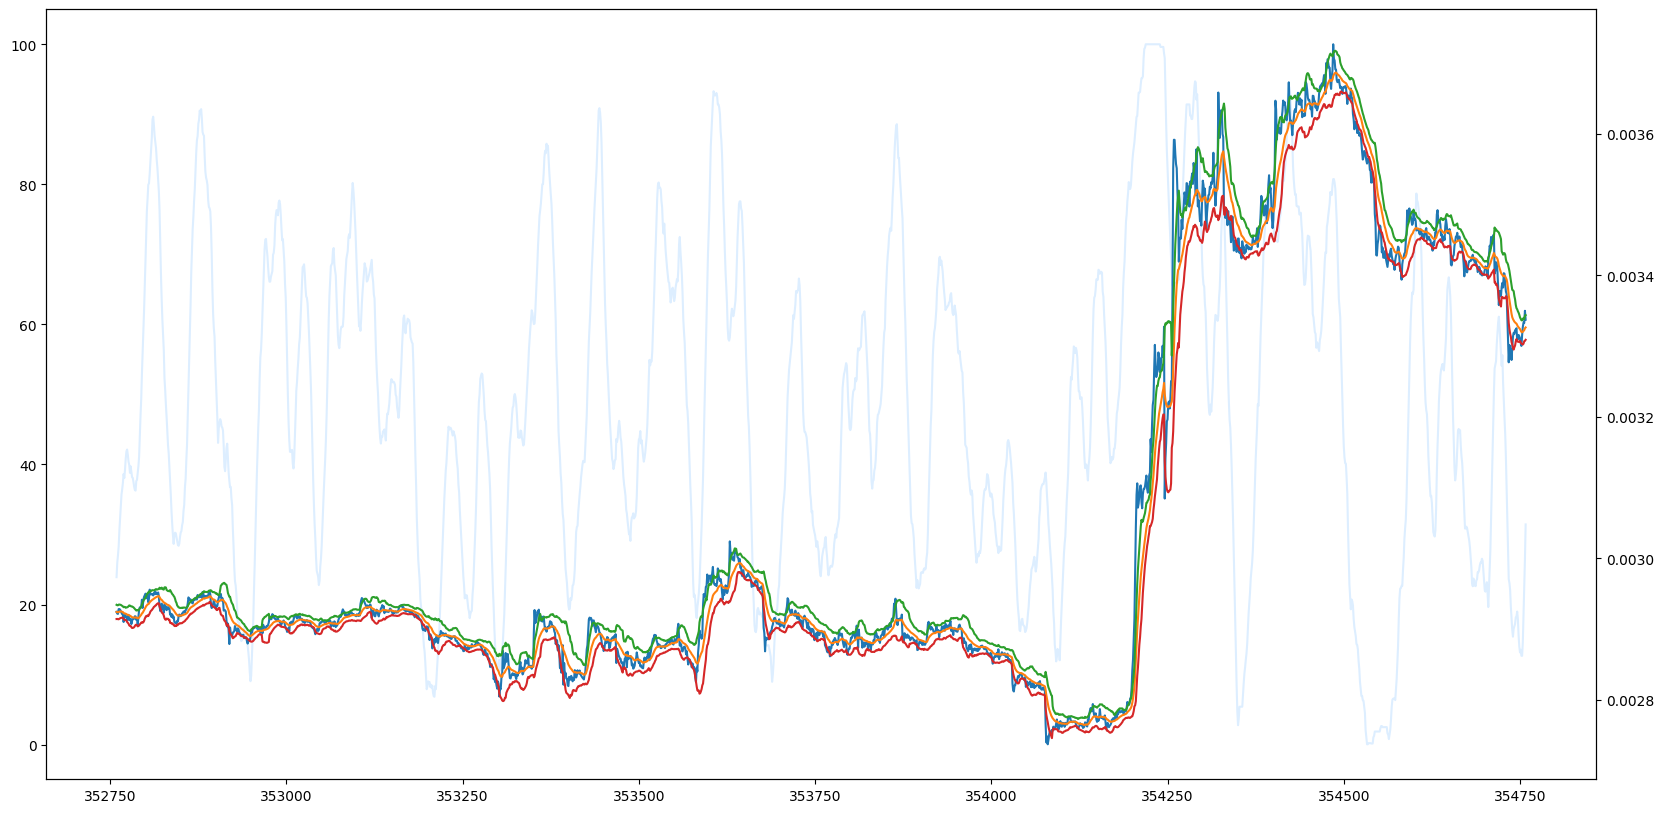

In [342]:
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(my_minute_data[-2000:]['keltner_coeff'], color='#DEF')
ax2.plot(my_minute_data[-2000:]['close'])
ax2.plot(my_minute_data[-2000:]['keltner'])
ax2.plot(my_minute_data[-2000:]['keltner_upper'])
ax2.plot(my_minute_data[-2000:]['keltner_lower'])

#### **My own indicators**

In [343]:
def add_my_indicators(data):
    time_deltas = [2, 6, 12, 24, 48, 72, 96, 168] #, 720, 1440, 2880, 4320]

    for t in time_deltas:
        data['price_prev_'+str(t)+'_hours'] = data['high'].shift(t)
        data['price_diff_'+str(t)+'_hours'] = data['high']-data['price_prev_'+str(t)+'_hours']
        data['price_velocity_'+str(t)+'_hours'] = (data['high']-data['price_prev_'+str(t)+'_hours'])/data['price_prev_'+str(t)+'_hours']

    return data

In [344]:
my_minute_data = add_my_indicators(my_minute_data)

In [350]:
my_minute_data['max_240_period'] = my_minute_data['high'].rolling(72).max().shift(-1)
my_minute_data['min_240_period'] = my_minute_data['low'].rolling(72).min().shift(-1)

In [351]:
my_minute_data['target'] = np.where(my_minute_data['max_240_period'] >= my_minute_data['high']*1.02, 1, 0)
my_minute_data['target'] = np.where(my_minute_data['min_240_period'] >= my_minute_data['high']*0.95, my_minute_data['target'], 0)

In [352]:
# offset = 1440

# max_list = []
# win_list = []
# loss_list = []

# for i in range(1, len(hist)-offset):
#     if not i%10000: print(i) 
#     max_list.append(max(hist['high'][i:i+offset]))
#     win_list.append(np.argmax(np.array(hist['high'][i:i+offset] >= hist['high'][i-1]*1.01)))
#     loss_list.append(np.argmax(np.array(hist['low'][i:i+offset] <= hist['high'][i-1]*0.95)))

# max_list2 = np.concatenate([np.array(max_list), np.array([np.nan for i in range(offset+1)])], axis=0)
# win_list2 = np.concatenate([np.array(win_list), np.array([np.nan for i in range(offset+1)])], axis=0)
# loss_list2 = np.concatenate([np.array(loss_list), np.array([np.nan for i in range(offset+1)])], axis=0)

In [361]:
my_minute_data_subset = my_minute_data[my_minute_data['72_period_lookback']==0].reset_index(drop=True)

In [362]:
sum(my_minute_data_subset['target'])

52350

In [363]:
window_size = 72 # 168

In [364]:
cols_remove = ['open', 'high', 'low', 'time', 'time_step', 'idx_prev', 'idx_next', 'dist_extrapolated', 'max_168_hour',
               '2_period_lookback', '4_period_lookback', '6_period_lookback', '12_period_lookback', '24_period_lookback',
               '48_period_lookback', '72_period_lookback', '96_period_lookback', '120_period_lookback', '240_period_lookback', 'volume']
cols_keep = [c for c in list(my_minute_data_subset.columns) if c not in cols_remove]

In [365]:
cols_keep

['close',
 'prev',
 'gain',
 'loss',
 'avg_gain_14',
 'avg_loss_14',
 'RS',
 'RSI',
 'high_14',
 'low_14',
 'Stochastic',
 'Stochastic_3_Avg',
 'Williams %R',
 'typical',
 'sd',
 'BOLU',
 'BOLD',
 'tr',
 'atr',
 'keltner',
 'keltner_upper',
 'keltner_lower',
 'keltner_coeff',
 'price_prev_2_hours',
 'price_diff_2_hours',
 'price_velocity_2_hours',
 'price_prev_6_hours',
 'price_diff_6_hours',
 'price_velocity_6_hours',
 'price_prev_12_hours',
 'price_diff_12_hours',
 'price_velocity_12_hours',
 'price_prev_24_hours',
 'price_diff_24_hours',
 'price_velocity_24_hours',
 'price_prev_48_hours',
 'price_diff_48_hours',
 'price_velocity_48_hours',
 'price_prev_72_hours',
 'price_diff_72_hours',
 'price_velocity_72_hours',
 'price_prev_96_hours',
 'price_diff_96_hours',
 'price_velocity_96_hours',
 'price_prev_168_hours',
 'price_diff_168_hours',
 'price_velocity_168_hours',
 'max_240_period',
 'min_240_period',
 'target']

In [366]:
raw_train_data = my_minute_data_subset.iloc[window_size:-window_size, :].loc[:, cols_keep].sample(frac=1).reset_index(drop=True)
raw_train_data_unshuffled = my_minute_data_subset.iloc[window_size:-window_size, :].loc[:, cols_keep].reset_index(drop=True)

In [367]:
raw_train_data_unshuffled

,close,prev,gain,loss,avg_gain_14,avg_loss_14,RS,RSI,high_14,low_14,...,price_velocity_72_hours,price_prev_96_hours,price_diff_96_hours,price_velocity_96_hours,price_prev_168_hours,price_diff_168_hours,price_velocity_168_hours,max_240_period,min_240_period,target
0,0.011280,0.011300,1.390000e-04,0.000000,0.000034,0.000036,0.662872,48.463115,0.011700,0.011027,...,0.160669,0.009615,0.001835,0.190848,0.008630,0.002820,0.326767,0.011700,0.009730,0
1,0.011190,0.011280,0.000000e+00,0.000028,0.000030,0.000038,0.575364,43.750000,0.011700,0.011027,...,0.141612,0.009502,0.001760,0.185224,0.008630,0.002632,0.304983,0.011700,0.009950,0
2,0.011100,0.011190,0.000000e+00,0.000101,0.000023,0.000045,0.419085,34.235172,0.011700,0.011027,...,0.121709,0.009490,0.001671,0.176080,0.008650,0.002511,0.290289,0.011700,0.010026,0
3,0.011060,0.011100,0.000000e+00,0.000071,0.000023,0.000042,0.443771,35.838780,0.011690,0.011027,...,0.111211,0.009520,0.001601,0.168172,0.008650,0.002471,0.285665,0.011700,0.010110,0
4,0.011134,0.011060,0.000000e+00,0.000030,0.000020,0.000044,0.372065,31.069042,0.011686,0.011027,...,0.098028,0.009510,0.001624,0.170768,0.008761,0.002373,0.270859,0.011700,0.010150,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125565,0.003426,0.003421,1.909677e-06,0.000000,0.000002,0.000003,0.476203,37.886286,0.003434,0.003398,...,-0.011917,0.003438,-0.000012,-0.003562,0.003627,-0.000202,-0.055563,0.003496,0.003398,1
125566,0.003429,0.003426,1.530629e-06,0.000000,0.000002,0.000003,0.568570,43.366523,0.003429,0.003398,...,-0.008982,0.003435,-0.000005,-0.001558,0.003621,-0.000191,-0.052820,0.003496,0.003398,0
125567,0.003423,0.003429,5.048467e-06,0.000000,0.000003,0.000002,0.733142,51.960263,0.003430,0.003398,...,-0.008213,0.003449,-0.000019,-0.005565,0.003619,-0.000189,-0.052292,0.003496,0.003398,0
125568,0.003421,0.003423,0.000000e+00,0.000007,0.000003,0.000002,0.784027,54.343647,0.003430,0.003400,...,-0.009826,0.003461,-0.000038,-0.011120,0.003617,-0.000194,-0.053625,0.003496,0.003398,1


In [368]:
def standardize(df, row_range=None, skip_cols=None):
    df = df.copy()
    if skip_cols is None:
        skip_cols = []
    elif type(skip_cols) == str:
        skip_cols = [skip_cols]
    if row_range is None: row_range = (0, len(df))
    df_rest = pd.concat([df.pop(x) for x in skip_cols], axis=1)
    df_mean = df.iloc[row_range[0]:row_range[1]:,:].mean()
    df_std = df.iloc[row_range[0]:row_range[1]:,:].std()
    return pd.concat([(df - df_mean) / df_std, df_rest], axis=1)

In [369]:
def normalize(df, row_range=None, skip_cols=None):
    df = df.copy()
    if skip_cols is None:
        skip_cols = []
    elif type(skip_cols) == str:
        skip_cols = [skip_cols]
    if row_range is None: row_range = (0, len(df))
    df_rest = pd.concat([df.pop(x) for x in skip_cols], axis=1)
    for i in list(df.columns):
        df[i] = (df[i]-min(df[i][row_range[0]:row_range[1]]))/(max(df[i][row_range[0]:row_range[1]])-min(df[i][row_range[0]:row_range[1]]))
    return pd.concat([df, df_rest], axis=1)

In [370]:
train_rows = int(len(raw_train_data_unshuffled)*0.8)
# train_rows
row_range=(0, train_rows)

In [371]:
train_data_unshuffled = standardize(raw_train_data_unshuffled, row_range=row_range, skip_cols='target')
train_data_unshuffled = normalize(train_data_unshuffled, row_range=row_range, skip_cols='target')

In [372]:
train_data_unshuffled

,close,prev,gain,loss,avg_gain_14,avg_loss_14,RS,RSI,high_14,low_14,...,price_velocity_72_hours,price_prev_96_hours,price_diff_96_hours,price_velocity_96_hours,price_prev_168_hours,price_diff_168_hours,price_velocity_168_hours,max_240_period,min_240_period,target
0,0.281573,0.282244,0.073196,0.000000,0.078324,0.028320,0.061867,0.484642,0.283285,0.297242,...,0.564065,0.216773,0.709770,0.536255,0.184989,0.676784,0.573434,0.282525,0.290238,0
1,0.278553,0.281573,0.000000,0.003912,0.068389,0.029897,0.053700,0.437510,0.283285,0.297242,...,0.548847,0.213126,0.707156,0.532166,0.184989,0.670979,0.559480,0.282525,0.299570,0
2,0.275533,0.278553,0.000000,0.014110,0.054479,0.035584,0.039114,0.342359,0.283285,0.297242,...,0.532954,0.212739,0.704054,0.525518,0.185635,0.667243,0.550069,0.282525,0.302794,0
3,0.274190,0.275533,0.000000,0.009919,0.054479,0.033163,0.041418,0.358396,0.282962,0.297242,...,0.524572,0.213707,0.701614,0.519769,0.185635,0.666008,0.547107,0.282525,0.306357,0
4,0.276673,0.274190,0.000000,0.004191,0.046200,0.034852,0.034725,0.310697,0.282832,0.297242,...,0.514045,0.213385,0.702415,0.521656,0.189216,0.662982,0.537624,0.282525,0.308054,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125565,0.018011,0.017853,0.001006,0.000000,0.004861,0.002710,0.044445,0.378871,0.016270,0.018645,...,0.426254,0.017450,0.645386,0.394918,0.023558,0.583489,0.328545,0.017226,0.021657,1
125566,0.018128,0.018011,0.000806,0.000000,0.005115,0.002271,0.053066,0.433675,0.016127,0.018645,...,0.428597,0.017351,0.645626,0.396374,0.023349,0.583807,0.330302,0.017226,0.021657,0
125567,0.017920,0.018128,0.002658,0.000000,0.005951,0.001871,0.068425,0.519614,0.016145,0.018645,...,0.429211,0.017815,0.645143,0.393461,0.023303,0.583868,0.330640,0.017226,0.021657,0
125568,0.017843,0.017920,0.000000,0.000951,0.005951,0.001700,0.073175,0.543449,0.016145,0.018712,...,0.427923,0.018201,0.644471,0.389423,0.023217,0.583724,0.329786,0.017226,0.021657,1


In [373]:
train_x_unshuffled = train_data_unshuffled.iloc[row_range[0]:row_range[1],:]
train_y_unshuffled = train_x_unshuffled.pop('target')
test_x_unshuffled = train_data_unshuffled.iloc[row_range[1]:,:]
test_y_unshuffled = test_x_unshuffled.pop('target')

In [374]:
train_x_unshuffled, train_y_unshuffled, test_x_unshuffled, test_y_unshuffled = np.array(train_x_unshuffled), np.array(train_y_unshuffled), np.array(test_x_unshuffled), np.array(test_y_unshuffled)

In [375]:
auc = tf.keras.metrics.AUC()

model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=2.5e-4), metrics=['accuracy', auc])

In [376]:
model.fit(
    train_x_unshuffled,
    train_y_unshuffled,
    validation_data = (test_x_unshuffled, test_y_unshuffled),
    epochs=10,
    batch_size=32
)

Epoch 1/10
3140/3140 [==============================] - 5s 2ms/step - loss: 0.5034 - accuracy: 0.7446 - auc_7: 0.8259 - val_loss: 0.4713 - val_accuracy: 0.7782 - val_auc_7: 0.8478
Epoch 2/10
3140/3140 [==============================] - 5s 1ms/step - loss: 0.4586 - accuracy: 0.7757 - auc_7: 0.8591 - val_loss: 0.4749 - val_accuracy: 0.7762 - val_auc_7: 0.8630
Epoch 3/10
3140/3140 [==============================] - 5s 2ms/step - loss: 0.4187 - accuracy: 0.8009 - auc_7: 0.8857 - val_loss: 0.4473 - val_accuracy: 0.7976 - val_auc_7: 0.8789
Epoch 4/10
3140/3140 [==============================] - 5s 2ms/step - loss: 0.3897 - accuracy: 0.8190 - auc_7: 0.9021 - val_loss: 0.4374 - val_accuracy: 0.8044 - val_auc_7: 0.8931
Epoch 5/10
3140/3140 [==============================] - 5s 2ms/step - loss: 0.3735 - accuracy: 0.8288 - auc_7: 0.9103 - val_loss: 0.4140 - val_accuracy: 0.8169 - val_auc_7: 0.8986
Epoch 6/10
3140/3140 [==============================] - 6s 2ms/step - loss: 0.3609 - accuracy: 0.835

In [377]:
preds = model.predict(np.concatenate([train_x_unshuffled, test_x_unshuffled], axis=0))

3925/3925 [==============================] - 4s 926us/step


In [380]:
preds_binary = np.array([p[0] for p in preds]) > 0.9
preds_binary = preds_binary*1

In [381]:
sum(preds_binary), len(preds_binary)

(14163, 125570)

In [382]:
train_data_unshuffled['preds'] = preds_binary

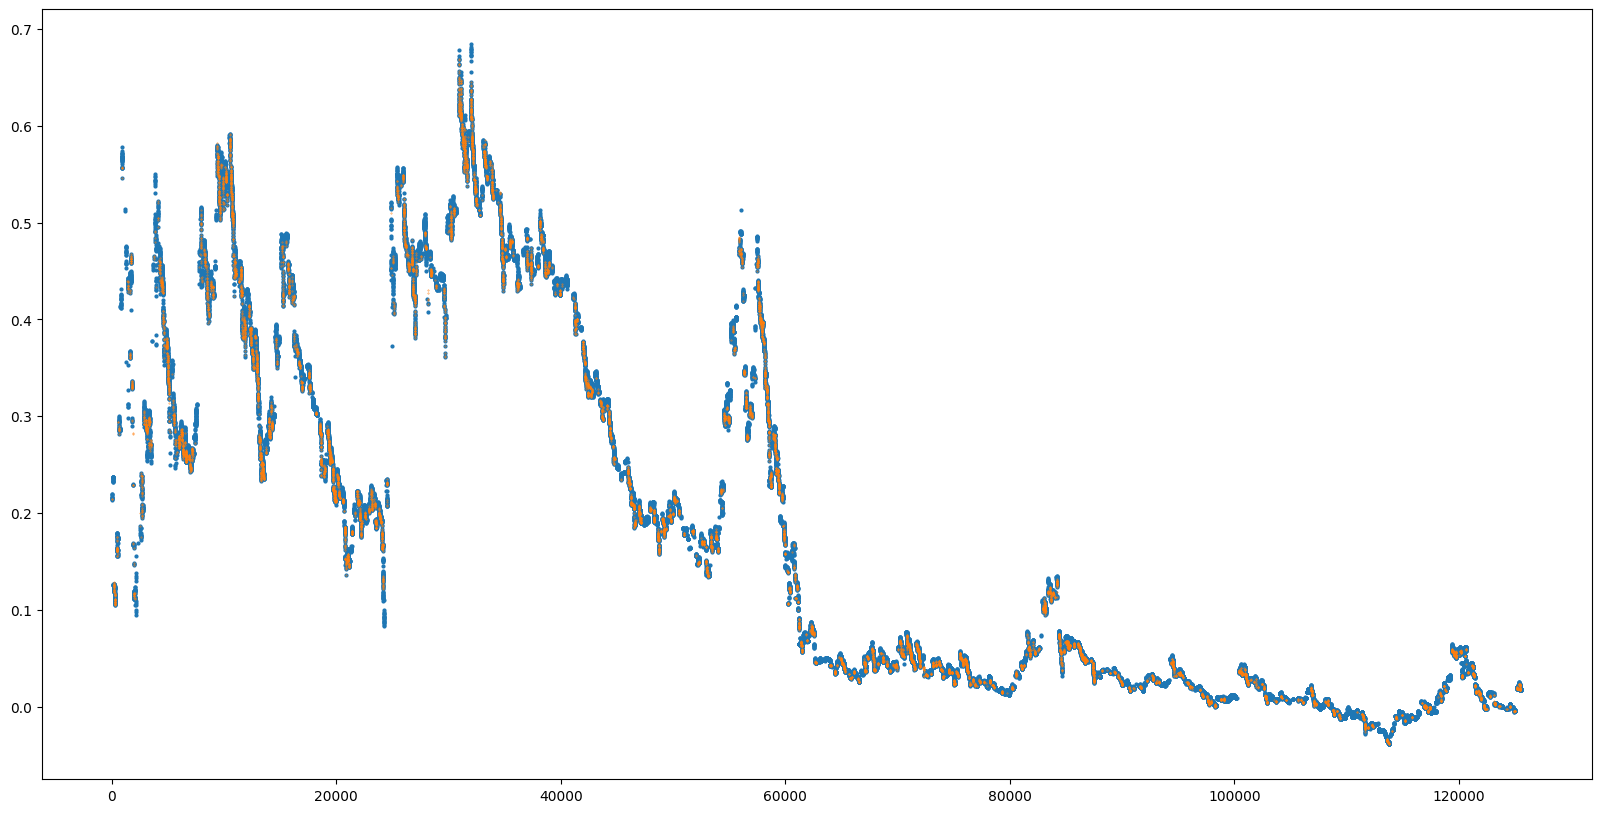

In [383]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(train_data_unshuffled[train_data_unshuffled['target']==1].index, train_data_unshuffled[train_data_unshuffled['target']==1]['close'], s=4)
plt.scatter(train_data_unshuffled[train_data_unshuffled['preds']==1].index, train_data_unshuffled[train_data_unshuffled['preds']==1]['close'], s=0.1)

In [384]:
from sklearn.metrics import confusion_matrix

confusion_matrix(train_data_unshuffled[row_range[1]:]['target'], train_data_unshuffled[row_range[1]:]['preds'])

array([[15339,    15],
       [ 8176,  1584]])

In [385]:
zz = pd.concat([train_data_unshuffled, my_minute_data_subset.iloc[window_size:-window_size, :][['time', 'time_step']].reset_index(drop=True)], axis=1)
zz

,close,prev,gain,loss,avg_gain_14,avg_loss_14,RS,RSI,high_14,low_14,...,price_velocity_96_hours,price_prev_168_hours,price_diff_168_hours,price_velocity_168_hours,max_240_period,min_240_period,target,preds,time,time_step
0,0.281573,0.282244,0.073196,0.000000,0.078324,0.028320,0.061867,0.484642,0.283285,0.297242,...,0.536255,0.184989,0.676784,0.573434,0.282525,0.290238,0,0,1408596300000,2014-08-21 04:45
1,0.278553,0.281573,0.000000,0.003912,0.068389,0.029897,0.053700,0.437510,0.283285,0.297242,...,0.532166,0.184989,0.670979,0.559480,0.282525,0.299570,0,0,1408597200000,2014-08-21 05:00
2,0.275533,0.278553,0.000000,0.014110,0.054479,0.035584,0.039114,0.342359,0.283285,0.297242,...,0.525518,0.185635,0.667243,0.550069,0.282525,0.302794,0,0,1408598100000,2014-08-21 05:15
3,0.274190,0.275533,0.000000,0.009919,0.054479,0.033163,0.041418,0.358396,0.282962,0.297242,...,0.519769,0.185635,0.666008,0.547107,0.282525,0.306357,0,0,1408599000000,2014-08-21 05:30
4,0.276673,0.274190,0.000000,0.004191,0.046200,0.034852,0.034725,0.310697,0.282832,0.297242,...,0.521656,0.189216,0.662982,0.537624,0.282525,0.308054,0,0,1408599900000,2014-08-21 05:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125565,0.018011,0.017853,0.001006,0.000000,0.004861,0.002710,0.044445,0.378871,0.016270,0.018645,...,0.394918,0.023558,0.583489,0.328545,0.017226,0.021657,1,0,1688525100000,2023-07-05 02:45
125566,0.018128,0.018011,0.000806,0.000000,0.005115,0.002271,0.053066,0.433675,0.016127,0.018645,...,0.396374,0.023349,0.583807,0.330302,0.017226,0.021657,0,0,1688526000000,2023-07-05 03:00
125567,0.017920,0.018128,0.002658,0.000000,0.005951,0.001871,0.068425,0.519614,0.016145,0.018645,...,0.393461,0.023303,0.583868,0.330640,0.017226,0.021657,0,0,1688526900000,2023-07-05 03:15
125568,0.017843,0.017920,0.000000,0.000951,0.005951,0.001700,0.073175,0.543449,0.016145,0.018712,...,0.389423,0.023217,0.583724,0.329786,0.017226,0.021657,1,0,1688527800000,2023-07-05 03:30


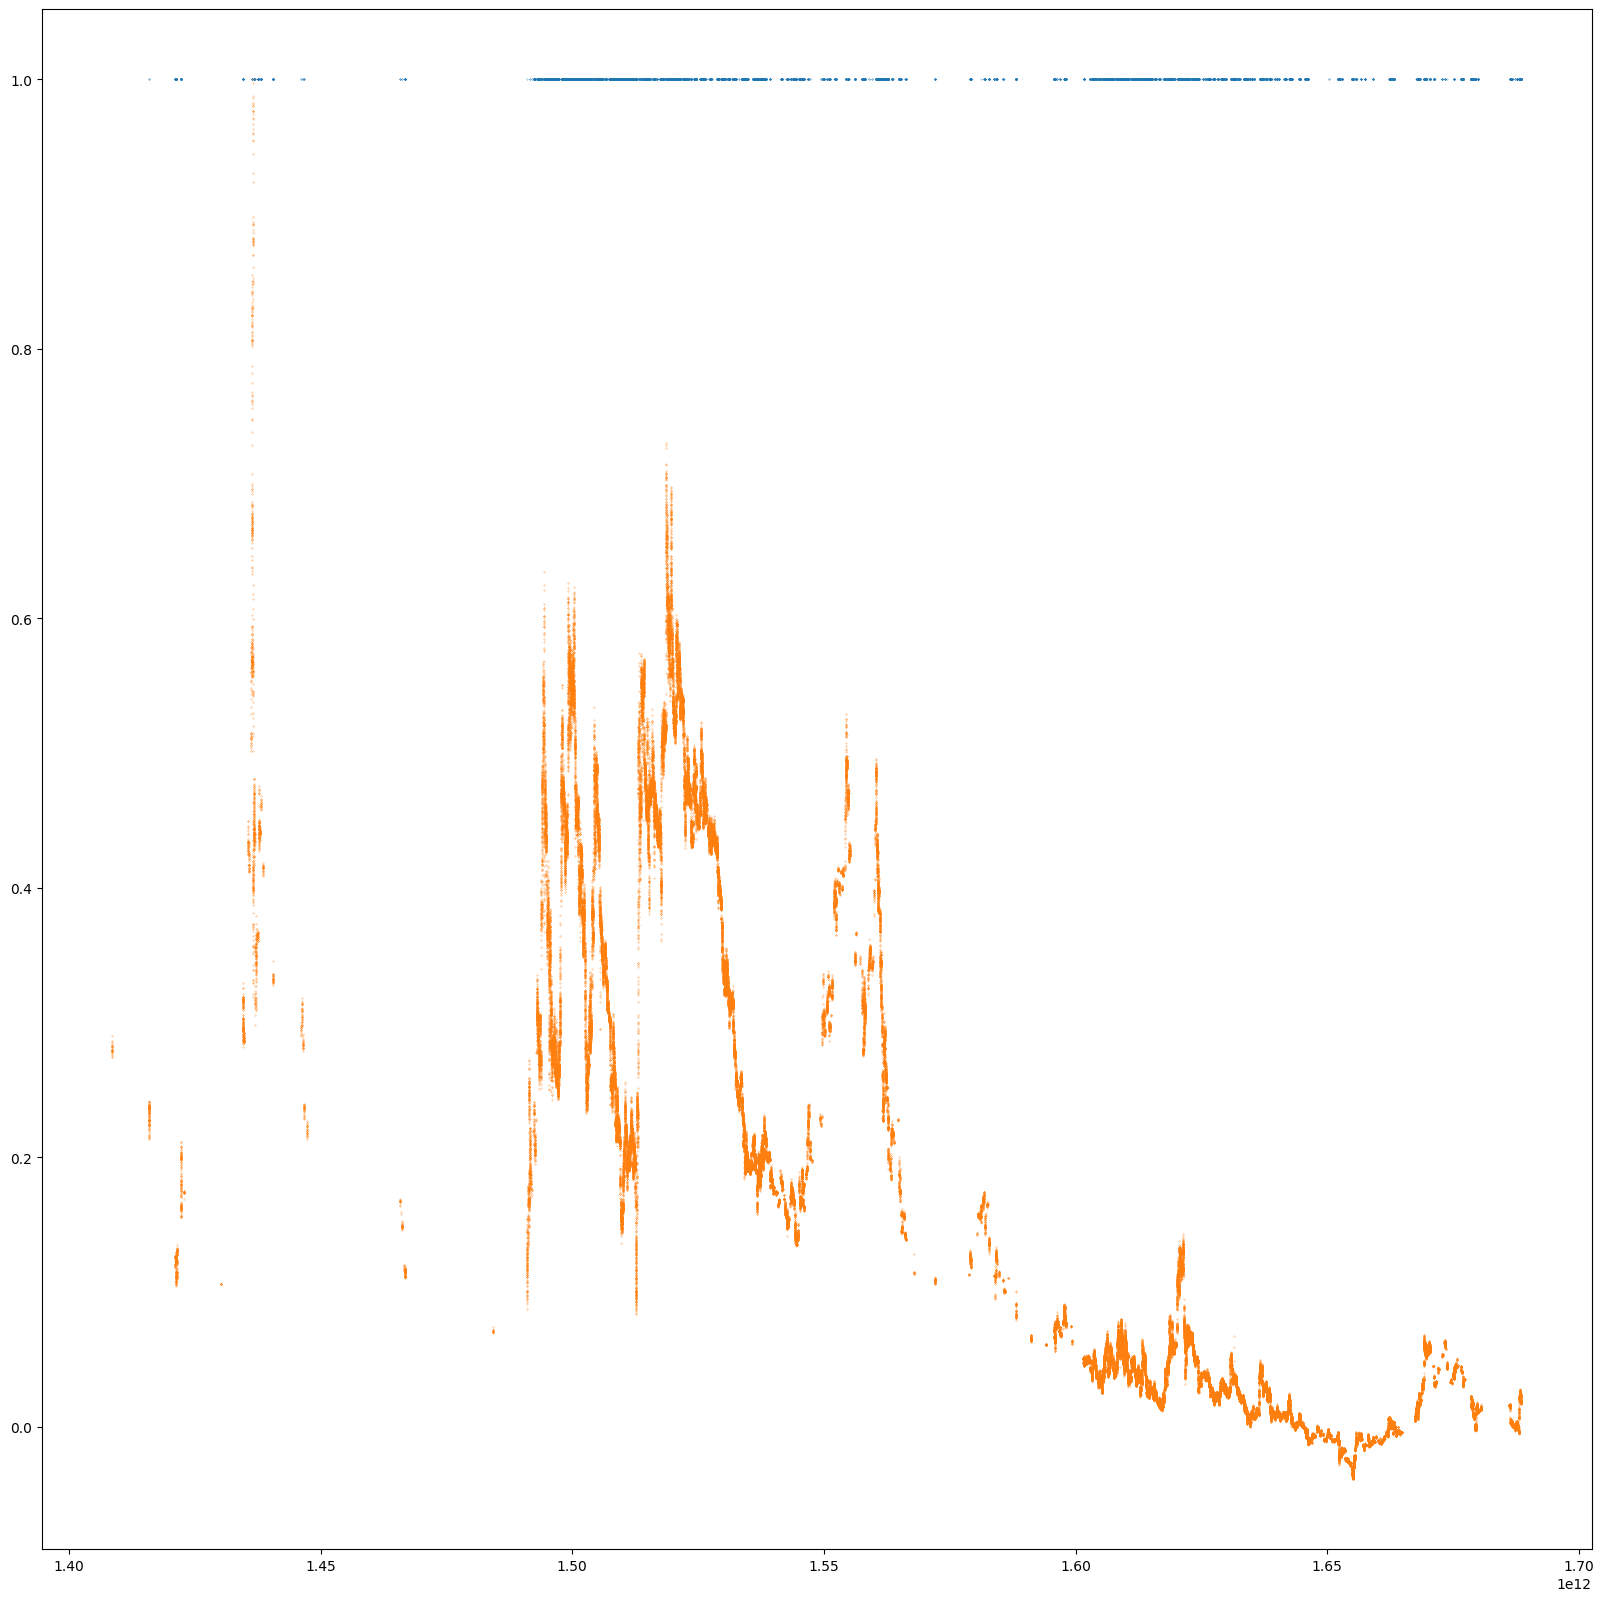

In [388]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plt.scatter(zz[zz['preds']==1]['time'], zz[zz['preds']==1]['preds'], s=0.05)
plt.scatter(zz['time'], zz['close'], s=0.05);